In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

final2_df = pd.read_csv("C:\\Users\\CHAITALI JAIN\\Desktop\\database for eds\\DiseaseAndSymptoms.csv")

In [4]:
final2_df.replace('0', pd.NA, inplace=True)
final2_df.describe()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
count,4920,4920,4920,4920,4572,3714,2934,2268,1944,1692,1512,1194,744,504,306,240,192,72
unique,41,34,48,54,50,38,32,26,21,22,21,18,11,8,4,3,3,1
top,Fungal infection,vomiting,vomiting,fatigue,high_fever,headache,nausea,abdominal_pain,abdominal_pain,yellowing_of_eyes,yellowing_of_eyes,irritability,malaise,muscle_pain,chest_pain,chest_pain,blood_in_sputum,muscle_pain
freq,120,822,870,726,378,348,390,264,276,228,198,120,126,72,96,144,72,72


In [5]:
all_unique_symptoms = set()
for i in range(1, 18):
    column_name = f'Symptom_{i}'
    unique_symptoms = final2_df[column_name].unique()
    all_unique_symptoms.update(unique_symptoms)

print(f"Total number of unique symptoms across all columns: {len(all_unique_symptoms)}")


print("Number of diseases that can be identified ",len(final2_df['Disease'].unique()))

Total number of unique symptoms across all columns: 132
Number of diseases that can be identified  41


In [6]:
# List of all symptom columns
symptom_cols = [f"Symptom_{i}" for i in range(1, 18)]

# Join symptoms into a single text string for each disease
final2_df['all_symptoms'] = final2_df[symptom_cols].fillna('').agg(' '.join, axis=1)

# Check result
print(final2_df[['Disease', 'all_symptoms']].head())


            Disease                                       all_symptoms
0  Fungal infection  itching  skin_rash  nodal_skin_eruptions  disc...
1  Fungal infection   skin_rash  nodal_skin_eruptions  dischromic _...
2  Fungal infection  itching  nodal_skin_eruptions  dischromic _pat...
3  Fungal infection  itching  skin_rash  dischromic _patches       ...
4  Fungal infection  itching  skin_rash  nodal_skin_eruptions      ...


# The next step is TF-IDF vectorization then K means Clustering 
Converts symptoms → TF-IDF features.

Groups them into k=41 clusters (same as number of diseases).

Adds a cluster column to your dataframe.

Plots the clusters in 2D (using PCA).

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: TF-IDF Vectorization ===
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(final2_df['all_symptoms'])

print("TF-IDF matrix shape:", X.shape)

# === Step 2: KMeans Clustering ===
k = 41  # number of diseases (clusters)
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
final2_df['cluster'] = kmeans.fit_predict(X)

# === Step 3: Compare Clusters with Actual Diseases ===
print(final2_df[['Disease', 'cluster']].head(20))


TF-IDF matrix shape: (4920, 135)
             Disease  cluster
0   Fungal infection       26
1   Fungal infection       26
2   Fungal infection       26
3   Fungal infection       26
4   Fungal infection       26
5   Fungal infection       26
6   Fungal infection       26
7   Fungal infection       26
8   Fungal infection       26
9   Fungal infection       26
10           Allergy       17
11           Allergy       17
12           Allergy       17
13           Allergy       17
14           Allergy       17
15           Allergy       17
16           Allergy       17
17           Allergy       17
18           Allergy       17
19           Allergy       17


 === Visualization (2D with PCA) ===


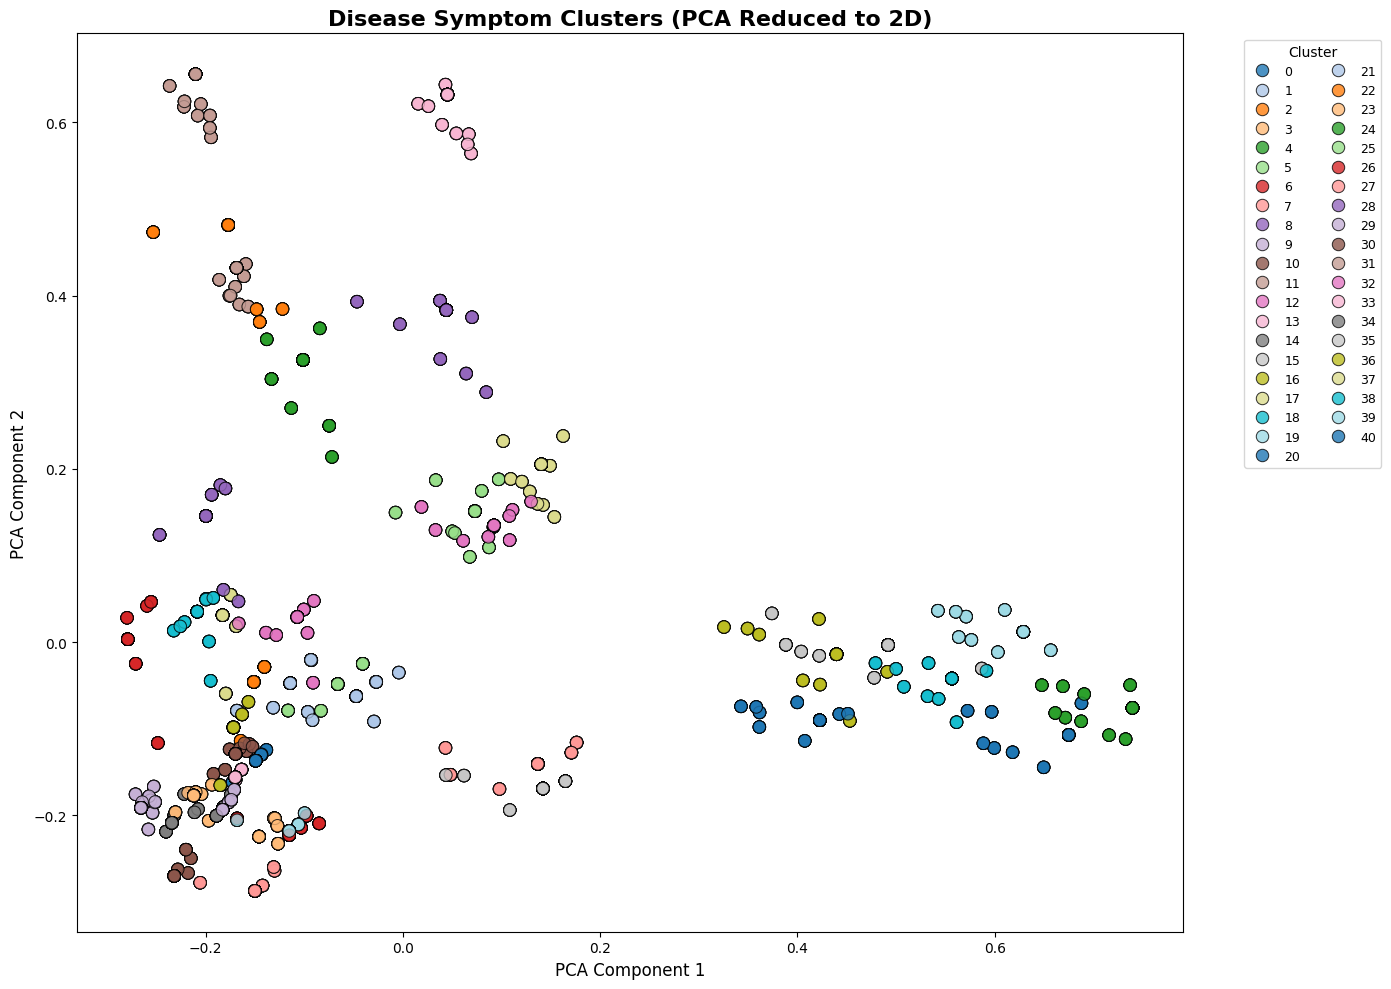

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# PCA for visualization
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(X.toarray())

plt.figure(figsize=(14,10))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1],
                hue=final2_df['cluster'], 
                palette='tab20', s=80, alpha=0.8, edgecolor='k')

plt.title("Disease Symptom Clusters (PCA Reduced to 2D)", fontsize=16, weight='bold')
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)

# Legend outside the plot
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=9)

plt.tight_layout()
plt.show()


# Training thorugh deep neural network 
What this does

Learns a disease prediction model using symptom text

Outputs test accuracy (you can also plot training vs validation loss/accuracy)

Allows you to input custom symptoms and predict a disease

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np

# === Step 1: Encode Labels ===
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(final2_df['Disease'])
y_categorical = to_categorical(y, num_classes=len(label_encoder.classes_))

# === Step 2: TF-IDF vectorization ===
vectorizer = TfidfVectorizer(max_features=2000)  # keep all symptoms
X_tfidf = vectorizer.fit_transform(final2_df['all_symptoms']).toarray()

# === Step 3: Train-test split ===
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y_categorical, test_size=0.2, random_state=42, stratify=y
)

# === Step 4: Neural Network ===
model_tfidf = Sequential([
    Dense(256, input_shape=(X_tfidf.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model_tfidf.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === Step 5: Train Model ===
history = model_tfidf.fit(
    X_train_tfidf, y_train_tfidf, 
    validation_data=(X_test_tfidf, y_test_tfidf),
    epochs=15, 
    batch_size=32, 
    verbose=1
)

# === Step 6: Evaluate ===
loss_tfidf, acc_tfidf = model_tfidf.evaluate(X_test_tfidf, y_test_tfidf, verbose=0)
print(f"TF-IDF Test Accuracy: {acc_tfidf:.2f}")

# === Step 7: Detailed Report ===
y_pred_probs = model_tfidf.predict(X_test_tfidf)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_tfidf, axis=1)

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


# === Step 8: Predict Example ===
example_symptoms = ["fever cough headache fatigue"]
example_features = vectorizer.transform(example_symptoms).toarray()
prediction = model_tfidf.predict(example_features)
predicted_disease = label_encoder.inverse_transform([prediction.argmax()])
print("Predicted Disease:", predicted_disease[0])


Epoch 1/15


c:\Users\CHAITALI JAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7640 - loss: 2.2184 - val_accuracy: 1.0000 - val_loss: 0.2140
Epoch 2/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.1353 - val_accuracy: 1.0000 - val_loss: 0.0171
Epoch 3/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0387 - val_accuracy: 1.0000 - val_loss: 0.0052
Epoch 4/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0174 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 5/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0112 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 6/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 9.8028e-04
Epoch 7/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 6.0029e-04
Epoch 8/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.000

In [38]:
# === Try new symptom examples ===
test_cases = [
    "itching skin_rash nodal_skin_eruptions",
    "abdominal_pain nausea vomiting yellowing_of_eyes",
    "chest_pain breathlessness sweating fatigue",
    "joint_pain back_pain stiffness",
    "high_fever headache chills muscle_pain"
]

for case in test_cases:
    features = vectorizer.transform([case]).toarray()
    prediction = model_tfidf.predict(features)
    predicted_disease = label_encoder.inverse_transform([prediction.argmax()])
    print(f"Symptoms: {case}")
    print(f"Predicted Disease: {predicted_disease[0]}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Symptoms: itching skin_rash nodal_skin_eruptions
Predicted Disease: Fungal infection

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Symptoms: abdominal_pain nausea vomiting yellowing_of_eyes
Predicted Disease: Chronic cholestasis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Symptoms: chest_pain breathlessness sweating fatigue
Predicted Disease: Heart attack

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Symptoms: joint_pain back_pain stiffness
Predicted Disease: Dengue

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Symptoms: high_fever headache chills muscle_pain
Predicted Disease: Malaria



Plot Accuracy and Loss Curves

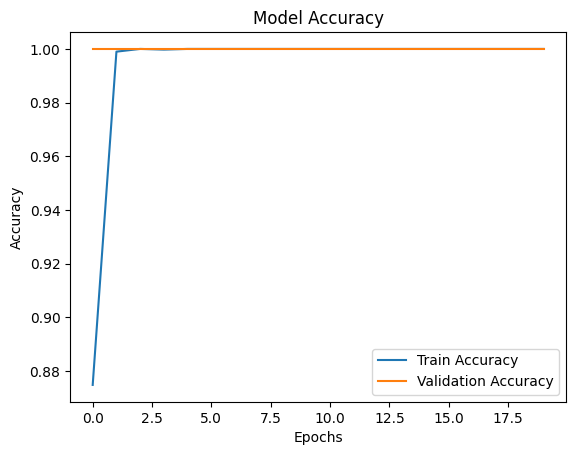

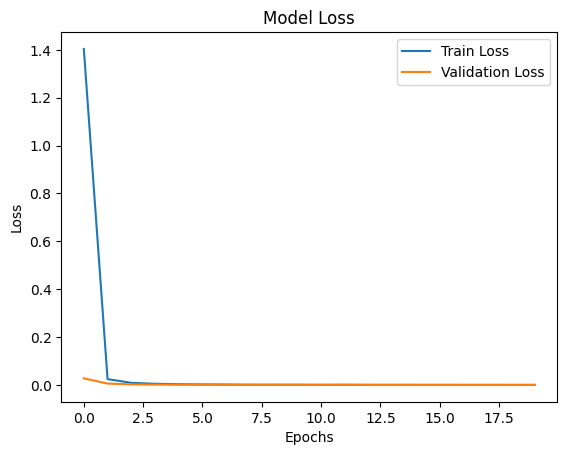

In [27]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Classification Report
 
It gives us Precision, Recall, F-1-Score, Support

In [28]:
from sklearn.metrics import classification_report
import numpy as np

# Predictions on test set
y_pred = model_tfidf.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        24
                            Common Cold       1.00      1.00      1.

# Spacy (pre trained emedding model) + Neural Network 
SEMNATIC MODEL

We use Word2Vec to convert symptoms (text) into dense numerical vectors that capture semantic meaning, so the model can understand relationships between symptoms beyond simple word counts (like in TF-IDF).

In [13]:
import spacy
nlp = spacy.load("en_core_web_md")

def get_spacy_vector(sentence):
    doc = nlp(sentence)
    return doc.vector

X_spacy = np.array([get_spacy_vector(s) for s in final2_df['all_symptoms']])
print("Shape:", X_spacy.shape)


Shape: (4920, 300)


In [39]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Features (symptom embeddings)
X = X_spacy   # or X_word2vec if using gensim

# Labels (diseases)
le = LabelEncoder()
y = le.fit_transform(final2_df['Disease'])
y = to_categorical(y)

# Split into train & test
X_train, X_test_embed, y_train, Y_test_embed = train_test_split(X, y, test_size=0.2, random_state=42)

# Neural Network
model_embed = Sequential()
model_embed.add(Dense(256, activation='relu', input_shape=(X.shape[1],)))
model_embed.add(Dropout(0.3))
model_embed.add(Dense(128, activation='relu'))
model_embed.add(Dropout(0.3))
model_embed.add(Dense(y.shape[1], activation='softmax'))

model_embed.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model_embed.fit(X_test_embed, Y_test_embed, validation_data=(X_test_embed, Y_test_embed), epochs=15, batch_size=32, verbose=1)

# Evaluate
loss, acc = model_embed.evaluate(X_test_embed, Y_test_embed, verbose=0)
print(f"Test Accuracy: {acc:.2f}")


Epoch 1/15


c:\Users\CHAITALI JAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0986 - loss: 3.6330 - val_accuracy: 0.1992 - val_loss: 3.4719
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1687 - loss: 3.3110 - val_accuracy: 0.2368 - val_loss: 2.9853
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2835 - loss: 2.8182 - val_accuracy: 0.4085 - val_loss: 2.4201
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3455 - loss: 2.3554 - val_accuracy: 0.4736 - val_loss: 1.9956
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4228 - loss: 2.0332 - val_accuracy: 0.5102 - val_loss: 1.6521
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4675 - loss: 1.7364 - val_accuracy: 0.6006 - val_loss: 1.3861
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5274 - loss: 1.5179 - val_accuracy: 0.7449 - val_loss: 1.1903
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5762 - loss: 1.3501 - val_accuracy: 0.7673 - val_loss: 1.0553
Epo

In [40]:
# Example: new symptoms
new_symptom_text = "fever cough headache fatigue"

vec = get_spacy_vector(new_symptom_text).reshape(1, -1)
pred = model_embed.predict(vec)
pred_disease = le.inverse_transform([np.argmax(pred)])
print("Predicted Disease:", pred_disease[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Disease: Pneumonia


In [33]:
# Another test case
new_symptom_text = "chest_pain shortness_of_breath dizziness"

vec = get_spacy_vector(new_symptom_text).reshape(1, -1)
pred = model_embed.predict(vec)
pred_disease = le.inverse_transform([np.argmax(pred)])
print("Predicted Disease:", pred_disease[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Disease: Malaria


Vizualize Training Performance

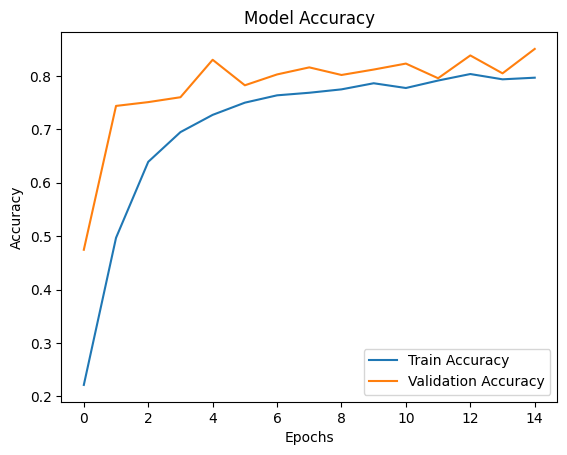

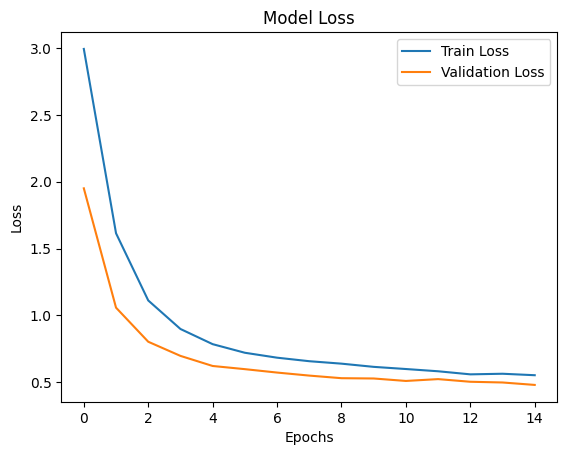

In [34]:
import matplotlib.pyplot as plt

# Plot training vs validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Comapre Accuracy of TF-IDF Vs Word2vec Emebedding 

In [42]:
# TF-IDF + NN result
loss_tfidf, acc_tfidf = model_tfidf.evaluate(X_test_tfidf, y_test_tfidf, verbose=0)

# Word2Vec/SpaCy + NN result
loss_embed, acc_embed = model_embed.evaluate(X_test_embed, Y_test_embed, verbose=0)

print(f"TF-IDF Model Accuracy: {acc_tfidf:.2f}")
print(f"Embedding Model Accuracy: {acc_embed:.2f}")


TF-IDF Model Accuracy: 1.00
Embedding Model Accuracy: 0.81


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


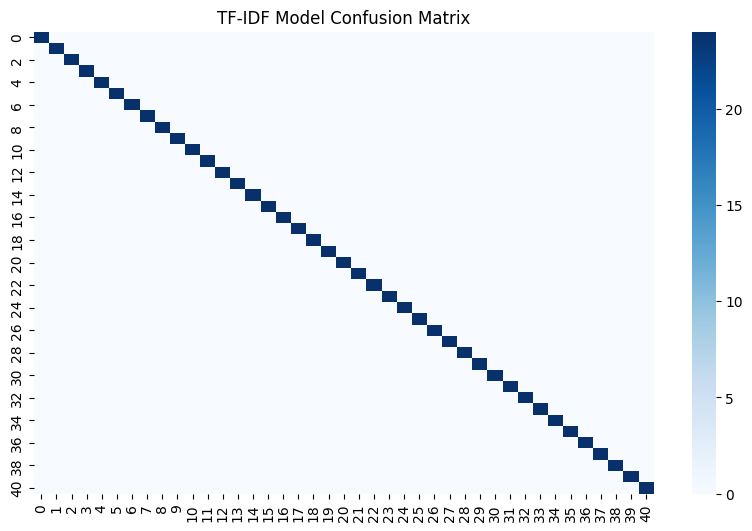

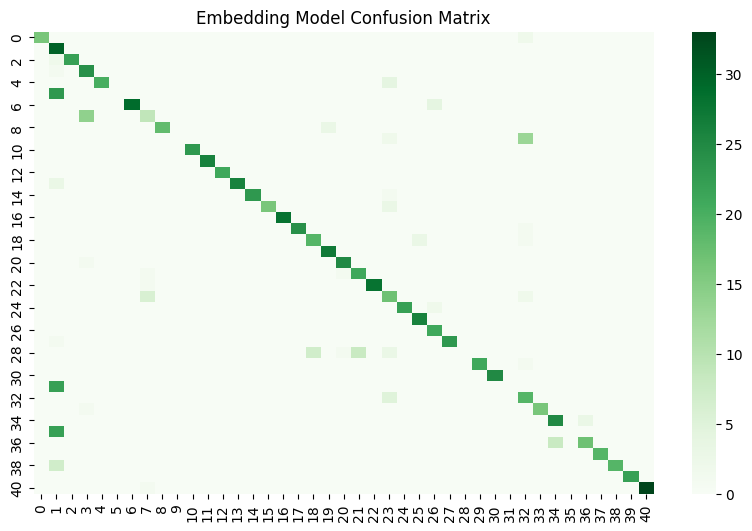

TF-IDF Model Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        24
           9       1.00      1.00      1.00        24
          10       1.00      1.00      1.00        24
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        24
          13       1.00      1.00      1.00        24
          14       1.00      1.00      1.00        24
          15       1.00      1.00      1.00        24
          16       1.00      1.00      1.00        24
     

c:\Users\CHAITALI JAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CHAITALI JAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CHAITALI JAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [44]:
# Confusion Matrices for both
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict TF-IDF model
y_pred_tfidf = np.argmax(model_tfidf.predict(X_test_tfidf), axis=1)
y_true_tfidf = np.argmax(y_test_tfidf, axis=1)

# Predict Embedding model
y_pred_embed = np.argmax(model_embed.predict(X_test_embed), axis=1)
y_true_embed = np.argmax(Y_test_embed, axis=1)

# Confusion matrix - TFIDF
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_true_tfidf, y_pred_tfidf), annot=False, cmap="Blues")
plt.title("TF-IDF Model Confusion Matrix")
plt.show()

# Confusion matrix - Embeddings
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_true_embed, y_pred_embed), annot=False, cmap="Greens")
plt.title("Embedding Model Confusion Matrix")
plt.show()

# Classification reports
print("TF-IDF Model Report:\n", classification_report(y_true_tfidf, y_pred_tfidf))
print("Embedding Model Report:\n", classification_report(y_true_embed, y_pred_embed))


# Add Explainable AI with LIME 

A Neural Network is like a black box: it gives predictions but doesn’t say why.

In healthcare AI, it’s not enough to predict the disease — doctors need to know which symptoms influenced the prediction.
A LIME visualization showing which symptoms influenced a prediction.
LIME and SHAP give this transparency:

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(final2_df['all_symptoms'])

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(final2_df['Disease'])

# Train/test split
from sklearn.model_selection import train_test_split
X_train_vec, X_test_vec, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# One-hot encode target
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Define NN
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_vec.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train_vec.toarray(), y_train_cat, 
                    epochs=10, batch_size=32,
                    validation_data=(X_test_vec.toarray(), y_test_cat))


Epoch 1/10


c:\Users\CHAITALI JAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4157 - loss: 3.0475 - val_accuracy: 0.9888 - val_loss: 1.5862
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9428 - loss: 0.7517 - val_accuracy: 1.0000 - val_loss: 0.0962
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9794 - loss: 0.1932 - val_accuracy: 1.0000 - val_loss: 0.0210
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9896 - loss: 0.0971 - val_accuracy: 1.0000 - val_loss: 0.0081
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9947 - loss: 0.0680 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9957 - loss: 0.0459 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9964 - loss: 0.0324 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9985 - loss: 0.0251 - val_accuracy: 1.0000 - val_

 Step 2: Evaluate Model

In [20]:
loss, acc = model.evaluate(X_test_vec.toarray(), y_test_cat)
print(f"Test Accuracy: {acc:.2f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.8388e-04
Test Accuracy: 1.00


 Step 3: Explain Predictions with LIME

In [21]:
from lime.lime_text import LimeTextExplainer
import numpy as np

# Class names are the diseases
class_names = label_encoder.classes_

explainer = LimeTextExplainer(class_names=class_names)

# Example: pick one test sample
idx = 5
sample_text = final2_df['all_symptoms'].iloc[X_test_vec.indices[idx]]
print("Sample symptoms:", sample_text)
print("True disease:", class_names[y_test[idx]])

# Define a prediction function for LIME
predict_fn = lambda texts: model.predict(vectorizer.transform(texts).toarray())

# Explain the instance
exp = explainer.explain_instance(sample_text, predict_fn, num_features=6)
print(exp.as_list())



Sample symptoms: itching  skin_rash  nodal_skin_eruptions  dischromic _patches             
True disease: Hypertension 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[(np.str_('nodal_skin_eruptions'), -0.00027202830031628855), (np.str_('dischromic'), -0.00026111169190719225), (np.str_('_patches'), -0.0002603135631017343), (np.str_('itching'), -0.00025962140019752586), (np.str_('skin_rash'), 1.5699982502696198e-05)]


The weights are very small and negative. That usually means:

The model is not strongly confident about this prediction (possibly misclassified).
Or the NN still needs more epochs / better preprocessing to learn stronger associations.

Next Steps -
Check prediction confidence

In [22]:
probs = predict_fn([sample_text])[0]
predicted_class = class_names[np.argmax(probs)]
print("Predicted disease:", predicted_class)
print("Prediction confidence:", np.max(probs))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted disease: Fungal infection
Prediction confidence: 0.9999651


# Implementing the SHAP 
This will give you both local explanations (per prediction) and global explanations (which symptoms matter overall for the model).

why use SHAP - Global + Local Explanations

Local: Like LIME, SHAP can explain a single prediction.

Global: It can also aggregate across all predictions to show which symptoms matter most overall.

Example: it might show that “fever” and “fatigue” are the top-2 symptoms driving predictions across all diseases.

Why run SHAP after LIME?

LIME helped you debug a few predictions → “is the model learning anything?”

SHAP will help you explain your model in the research paper → “here’s how symptoms influence diseases overall.”

In short:

LIME = local microscope 

SHAP = local + global + theory-backed telescope 

TypeError: 'numpy.float64' object is not iterable

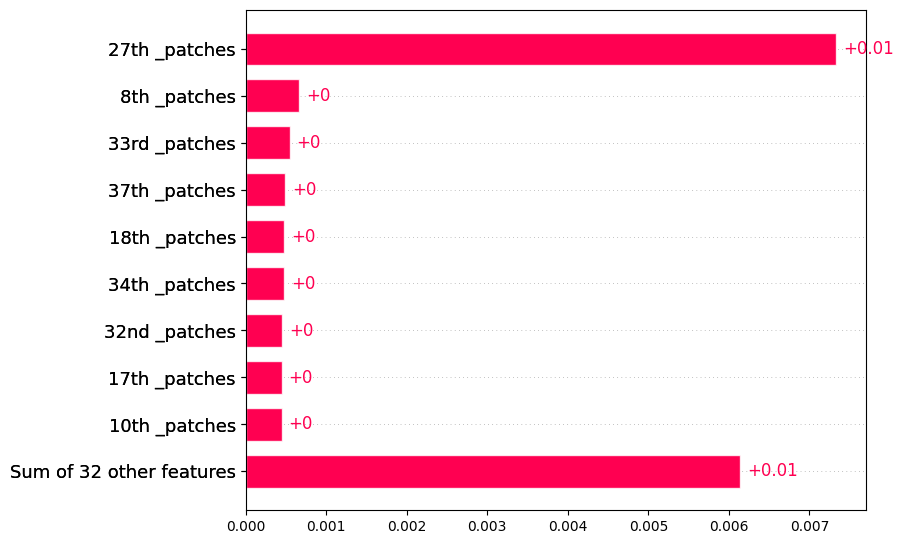

In [52]:
import pandas as pd
import shap

# Get feature names from TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()
# Convert text → vectors before SHAP
X_test_array = X_test_vec.toarray()
# Wrap train & test arrays into DataFrames
X_train_df = pd.DataFrame(X_train_vec.toarray(), columns=feature_names)
X_test_df = pd.DataFrame(X_test_array, columns=feature_names)

# Recreate SHAP explainer with DataFrame (keeps feature names)
explainer = shap.Explainer(model, X_train_df)

# Pick a few test samples
sample_data = X_test_df.sample(5, random_state=42)

# Compute SHAP values
shap_values = explainer(sample_data)

# Plot for first sample
shap.plots.bar(shap_values[0])


This will create a beeswarm plot (or a bar version) that tells you:

Which symptoms are most predictive across the whole dataset.
How their presence/absence shifts disease predictions.

Next Step (Global Feature Importance with SHAP)

So far, we explained single samples. Next, let’s check global importance across all test data to see which symptoms generally matter the most in predicting diseases.

PermutationExplainer explainer: 985it [01:00, 13.63it/s]                         
C:\Users\CHAITALI JAIN\AppData\Local\Temp\ipykernel_20600\3359443989.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 0], X_test_df, feature_names=feature_names, plot_type="bar")


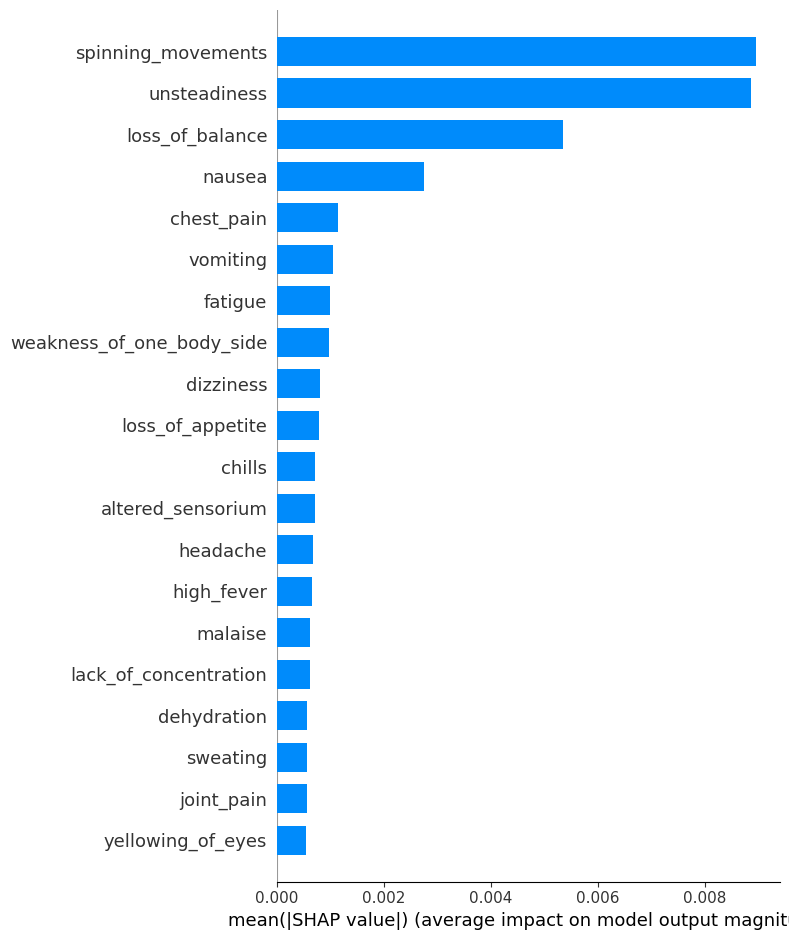

In [ ]:
# Global explanation across the test set
shap_values = explainer(X_test_df)

# Summary plot - shows overall symptom importance
# Example: pick class index 0 (first disease in label encoder)
shap.summary_plot(shap_values[:, :, 0], X_test_df, feature_names=feature_names, plot_type="bar")



PermutationExplainer explainer: 985it [01:10, 11.56it/s]                         
C:\Users\CHAITALI JAIN\AppData\Local\Temp\ipykernel_20600\3429800637.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df, feature_names=feature_names, plot_type="bar")


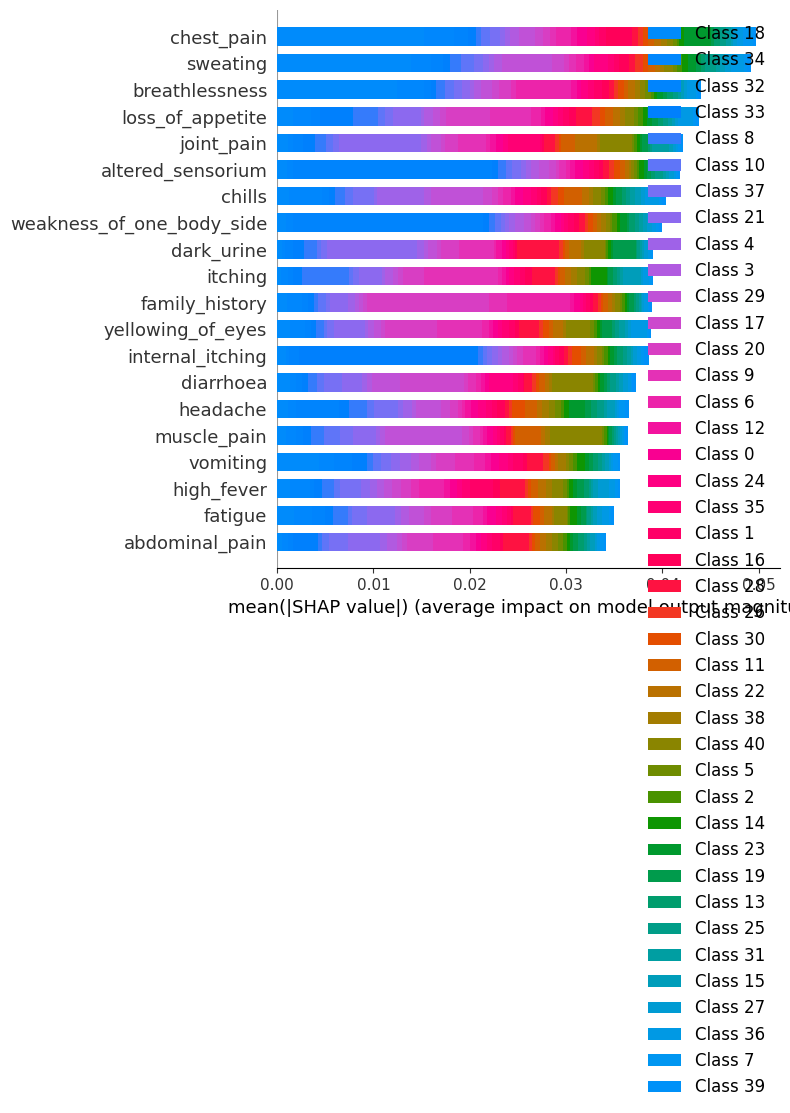

In [ ]:
# Global explanation across the test set
shap_values = explainer(X_test_df)
# Bar plot version for better readability
shap.summary_plot(shap_values, X_test_df, feature_names=feature_names, plot_type="bar")


# Step 6: Evaluate Model Performance

Generate metrics:
Accuracy, Precision, Recall, F1-score
Confusion matrix (to see which diseases get mixed up)
Plot these results for clarity.

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        18
                                   AIDS       1.00      1.00      1.00        30
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        23
                       Bronchial Asthma       1.00      1.00      1.00        33
                   Cervical spondylosis       1.00      1.00      1.00        23
                            Chicken pox       1.00      1.00      1.00        21
                    Chronic cholestasis       1.00      1.00      1.00        15
                            Common Cold      

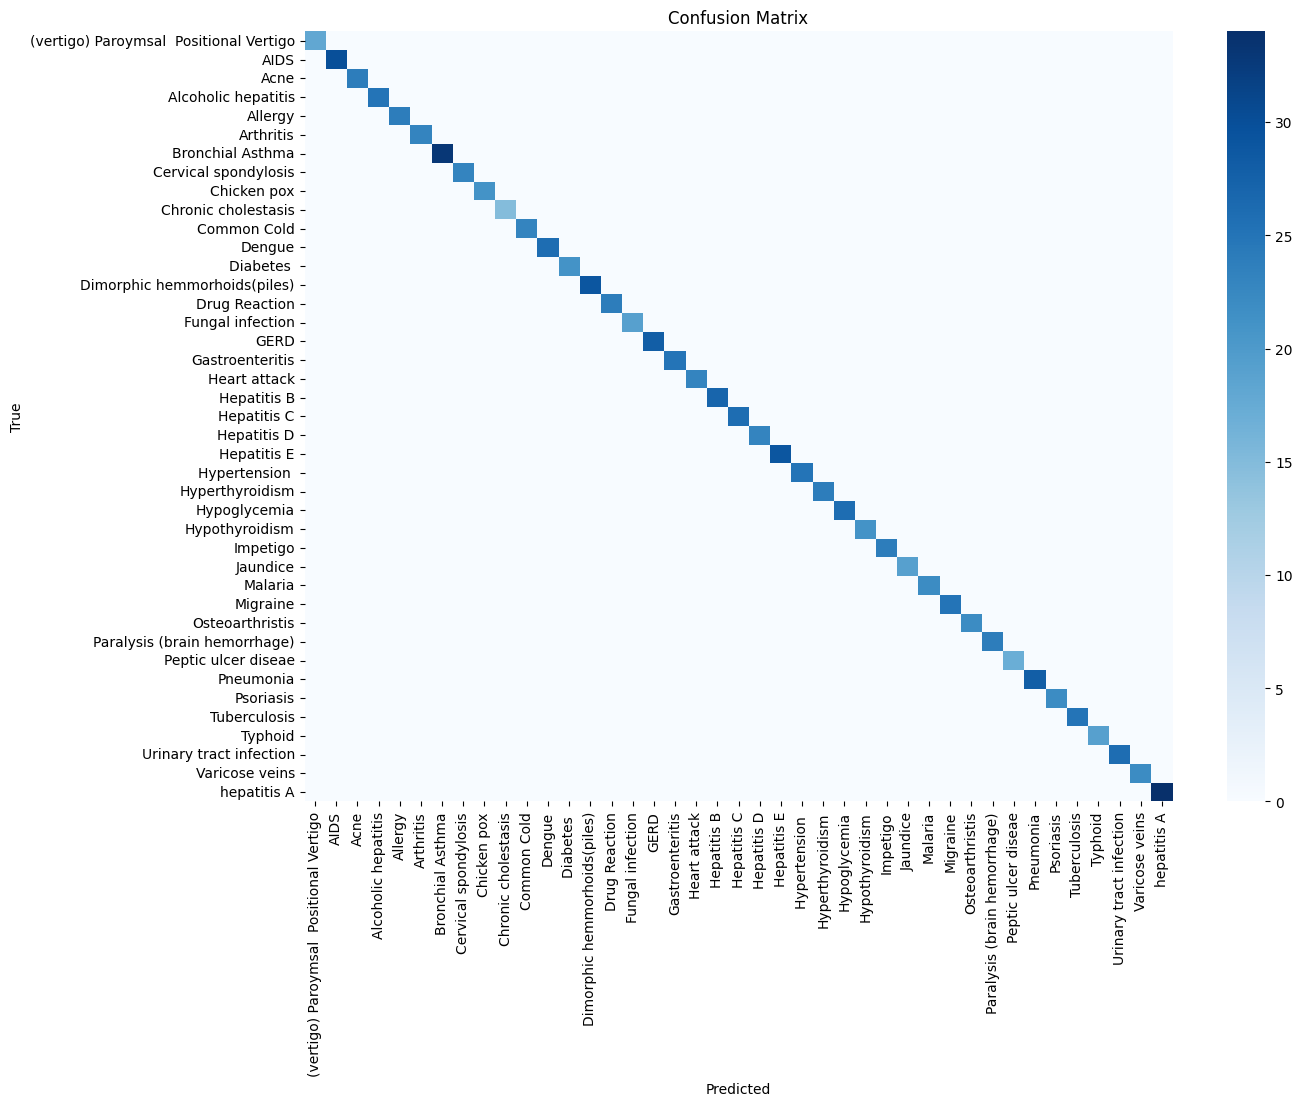

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Predict on test data
y_pred_probs = model.predict(X_test_vec)   # probabilities
y_pred_classes = y_pred_probs.argmax(axis=1)  # predicted class indices

# 2. Decode back to disease names
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

# 3. Classification report
print("Classification Report:\n")
print(classification_report(y_test_labels, y_pred_labels))

# 4. Accuracy
print("Test Accuracy:", accuracy_score(y_test_labels, y_pred_labels))

# 5. Confusion Matrix
plt.figure(figsize=(14,10))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)

sns.heatmap(cm, 
            annot=False, 
            fmt="d", 
            cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


The above graph give us Precision, Recall, F1 per disease

Overall accuracy
A heatmap confusion matrix (dark diagonal = good, off-diagonal = misclassifications)

# save model + vectorize 

In [ ]:
import joblib

# Save model
model.save("disease_prediction_model.h5")

# Save TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# Save label encoder
joblib.dump(label_encoder, "label_encoder.pkl")

print("✅ Model, vectorizer, and encoder saved successfully!")


✅ Model, vectorizer, and encoder saved successfully!


In [ ]:
from tensorflow.keras.models import load_model

# Load back
loaded_model = load_model("disease_prediction_model.h5")
loaded_vectorizer = joblib.load("tfidf_vectorizer.pkl")
loaded_encoder = joblib.load("label_encoder.pkl")

# Test prediction
sample = "itching skin_rash nodal_skin_eruptions"
X_sample = loaded_vectorizer.transform([sample])
y_pred = loaded_model.predict(X_sample).argmax(axis=1)
print("Predicted disease:", loaded_encoder.inverse_transform(y_pred)[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Predicted disease: Fungal infection
